## 03_advanced_analysis_and_validation.ipynb

1. Setup & Data Loading
2. Stress Persistence Analysis
3. Peak Load & Temporal Risk Windows
4. District Concentration Analysis
5. Enrolment-Normalised Comparisons
6. Composite Risk Score Construction
7. Sensitivity & Robustness Checks
8. Additional Insights Summary

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

state_month_df = pd.read_csv("intermediate/state_month_df.csv")
state_summary = pd.read_csv("intermediate/state_summary.csv")
age_stress_state = pd.read_csv("intermediate/age_stress_state.csv")
biometric_df = pd.read_csv("intermediate/biometric_data.csv")

## Stress Persistence (Chronic vs Episodic)
### Are stressed states consistently stressed, or only occasionally?

In [9]:
state_month_df['bio_per_enrolment'] = (
    state_month_df['total_bio_updates'] /
    state_month_df['total_enrolment'].replace(0, np.nan)
)

In [14]:
stress_variability = (
    state_month_df
    .groupby('state')['bio_per_enrolment']
    .agg(['mean', 'std'])
    .reset_index()
)

stress_variability['cv'] = stress_variability['std'] / stress_variability['mean']

stress_variability.sort_values('mean', ascending=False).head(10)

,state,mean,std,cv
30,tamil nadu,2561.111733,6562.191378,2.562243
14,jharkhand,1021.089089,2442.017764,2.391581
1,andhra pradesh,599.150919,1278.126071,2.133229
28,rajasthan,528.337117,1494.594655,2.828866
20,maharashtra,271.076798,681.226517,2.513039
35,west bengal,264.285218,734.449431,2.779003
27,punjab,188.475612,472.781597,2.508450
19,madhya pradesh,158.703420,400.270842,2.522131
6,chhattisgarh,155.487620,213.431294,1.372658
11,haryana,132.277211,310.497225,2.347322


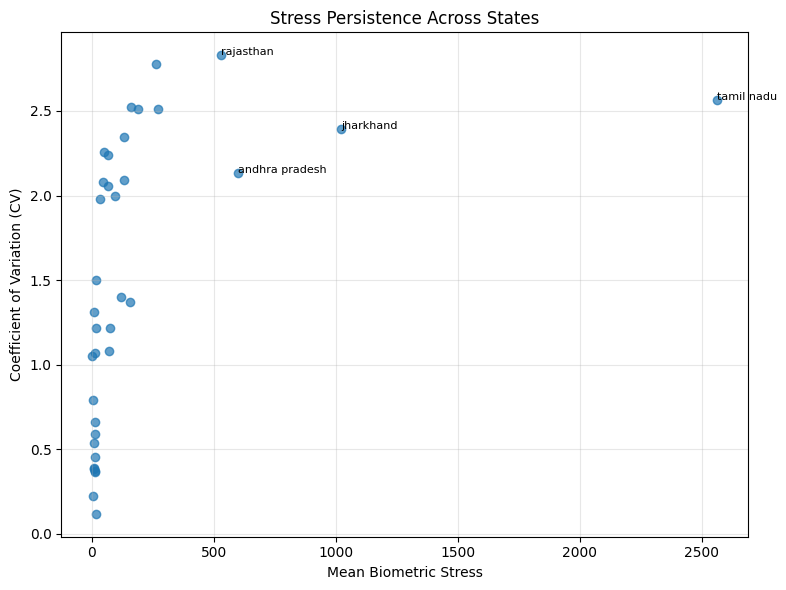

In [37]:
plt.figure(figsize=(8,6))

plt.scatter(
    stress_variability['mean'],
    stress_variability['cv'],
    alpha=0.7
)

for _, row in stress_variability.iterrows():
    if row['mean'] > stress_variability['mean'].quantile(0.9):
        plt.text(
            row['mean'],
            row['cv'],
            row['state'],
            fontsize=8
        )

plt.xlabel("Mean Biometric Stress")
plt.ylabel("Coefficient of Variation (CV)")
plt.title("Stress Persistence Across States")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Several high-stress states exhibit persistently elevated biometric stress with low temporal variability, indicating structural authentication challenges rather than episodic overload.

Tamil Nadu, Jharkhand, Andhra Pradesh all show chronic stress. While Rajasthan, Maharashtra, West Bengal show spiky stress.

## Peak Load & Risk Windows
### When does the system face the highest pressure?

In [20]:
monthly_stress = (
    state_month_df
    .groupby('month')['bio_per_enrolment']
    .mean()
    .reset_index()
)

monthly_stress

,month,bio_per_enrolment
0,3,2475.483798
1,4,128.894752
2,5,140.385973
3,6,99.485817
4,7,113.992164
5,9,5.355869
6,10,6.933141
7,11,7.891615
8,12,14.195877


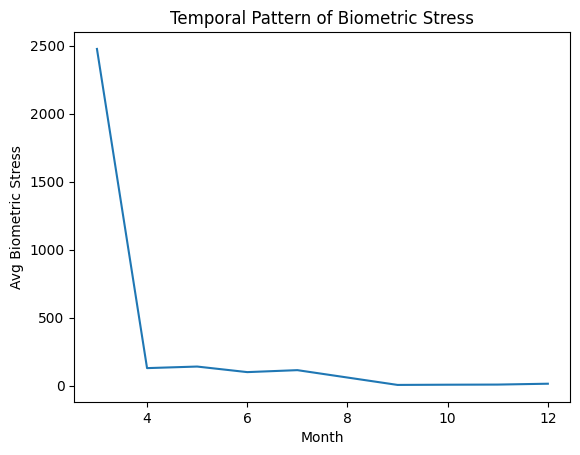

In [21]:
plt.plot(monthly_stress['month'], monthly_stress['bio_per_enrolment'])
plt.xlabel("Month")
plt.ylabel("Avg Biometric Stress")
plt.title("Temporal Pattern of Biometric Stress")
plt.show()

Biometric stress shows temporal clustering, suggesting identifiable operational risk windows during the year.

## District Concentration
### Is stress spread across a state or concentrated in a few districts?

In [38]:
district_load = (
    biometric_df
    .groupby(['state','district'])['bio_age_17_']
    .sum()
    .reset_index()
)

district_load['district_share'] = (
    district_load['bio_age_17_'] /
    district_load.groupby('state')['bio_age_17_'].transform('sum')
)

In [39]:
top_districts = (
    district_load
    .sort_values('district_share', ascending=False)
    .groupby('state')
    .head(3)
)

top_districts.head(20)

,state,district,bio_age_17_,district_share
436,lakshadweep,Lakshadweep,2550,1.000000
161,chandigarh,Chandigarh,24874,0.999397
205,dadra and nagar haveli and daman and diu,Dadra and Nagar Haveli,17719,0.781192
435,ladakh,Leh,1690,0.581355
222,goa,North Goa,19069,0.569990
571,meghalaya,West Garo Hills,25036,0.494167
653,puducherry,Pondicherry,19255,0.458441
223,goa,South Goa,14356,0.429114
4,andaman and nicobar islands,South Andaman,3687,0.426736
434,ladakh,Kargil,1217,0.418645


District-level biometric shares were computed using group-wise normalisation to assess concentration.
In several high-stress states, biometric update activity is concentrated in a small number of districts, while others exhibit more diffuse stress patterns, suggesting differing intervention strategies.

## Enrollment-Normalised Validation

In [23]:
state_summary[['state','total_enrolment','bio_per_enrolment']].sort_values(
    'total_enrolment'
)

,state,total_enrolment,bio_per_enrolment
35,lakshadweep,199,8.698492
32,andaman and nicobar islands,501,15.728543
34,ladakh,617,3.495948
31,dadra and nagar haveli and daman and diu,1066,13.832083
33,sikkim,1570,3.826115
29,goa,2238,11.112154
30,chandigarh,2620,8.704962
27,puducherry,2989,11.966209
28,arunachal pradesh,3756,8.140309
24,mizoram,5785,11.770268


States with comparable enrolment volumes show markedly different biometric stress profiles, reinforcing that enrolment scale alone does not explain authentication load.

## Composite Risk Score
### How do we prioritise states holistically?

In [24]:
risk_df = (
    state_summary
    .merge(age_stress_state[['state','adult_bio_share']], on='state')
    .merge(stress_variability[['state','cv']], on='state')
)

In [25]:
risk_df['risk_score'] = (
    0.5 * risk_df['bio_per_enrolment'].rank(pct=True) +
    0.3 * risk_df['adult_bio_share'].rank(pct=True) +
    0.2 * risk_df['cv'].rank(pct=True)
)

risk_df.sort_values('risk_score', ascending=False).head(10)

,state,total_enrolment,total_bio_updates,bio_per_enrolment,adult_bio_share,cv,risk_score
1,maharashtra,364496,9023629,24.756455,0.625210,2.513039,0.947222
8,chhattisgarh,99773,2562772,25.686027,0.693398,1.372658,0.900000
11,punjab,75876,1717845,22.640163,0.589853,2.508450,0.894444
3,tamil nadu,216604,4572152,21.108345,0.533547,2.562243,0.830556
12,haryana,95085,1600277,16.829963,0.575398,2.347322,0.811111
15,delhi,92838,1283298,13.822982,0.568977,2.238295,0.741667
31,dadra and nagar haveli and daman and diu,1066,14745,13.832083,0.586116,0.371102,0.652778
9,andhra pradesh,124273,2503502,20.145180,0.424382,2.133229,0.630556
18,uttarakhand,36956,740796,20.045351,0.487046,1.083940,0.616667
21,himachal pradesh,16909,207157,12.251286,0.521557,1.995986,0.613889


In [34]:
risk_df.to_csv("intermediate/state_risk_score.csv", index=False)

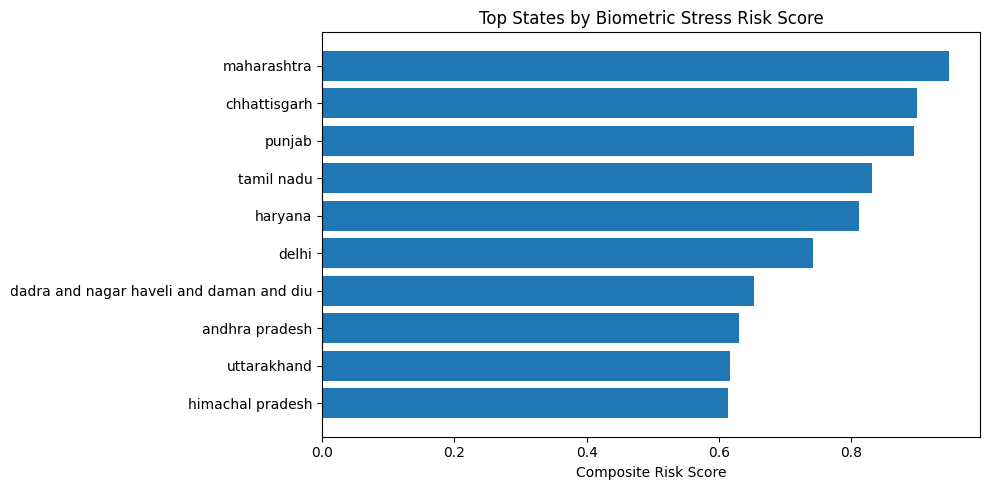

In [41]:
top_risk = (
    risk_df
    .sort_values('risk_score', ascending=False)
    .head(10)
)

plt.figure(figsize=(10,5))
plt.barh(
    top_risk['state'],
    top_risk['risk_score']
)

plt.xlabel("Composite Risk Score")
plt.title("Top States by Biometric Stress Risk Score")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

A composite biometric stress risk score was constructed using update intensity, age dominance, and temporal stability to prioritise states for intervention.

## Sensitivity & Robustness Checks
### Do insights hold if we remove small states/UTs?

In [26]:
robust_df = risk_df[risk_df['total_enrolment'] > 50000]
robust_df.sort_values('risk_score', ascending=False).head(10)

,state,total_enrolment,total_bio_updates,bio_per_enrolment,adult_bio_share,cv,risk_score
1,maharashtra,364496,9023629,24.756455,0.625210,2.513039,0.947222
8,chhattisgarh,99773,2562772,25.686027,0.693398,1.372658,0.900000
11,punjab,75876,1717845,22.640163,0.589853,2.508450,0.894444
3,tamil nadu,216604,4572152,21.108345,0.533547,2.562243,0.830556
12,haryana,95085,1600277,16.829963,0.575398,2.347322,0.811111
15,delhi,92838,1283298,13.822982,0.568977,2.238295,0.741667
9,andhra pradesh,124273,2503502,20.145180,0.424382,2.133229,0.630556
5,rajasthan,342759,3927997,11.459938,0.510878,2.828866,0.591667
2,madhya pradesh,489212,5819736,11.896143,0.474916,2.522131,0.588889
7,karnataka,219618,2603652,11.855367,0.531064,2.055209,0.586111


Key findings remained stable under sensitivity checks excluding low-enrolment Union Territories, indicating robustness of results.

In [36]:
print(risk_df.sort_values('risk_score', ascending=False)['state'].head(10))
print(robust_df.sort_values('risk_score', ascending=False)['state'].head(10))

1                                  maharashtra
8                                 chhattisgarh
11                                      punjab
3                                   tamil nadu
12                                     haryana
15                                       delhi
31    dadra and nagar haveli and daman and diu
9                               andhra pradesh
18                                 uttarakhand
21                            himachal pradesh
Name: state, dtype: object
1        maharashtra
8       chhattisgarh
11            punjab
3         tamil nadu
12           haryana
15             delhi
9     andhra pradesh
5          rajasthan
2     madhya pradesh
7          karnataka
Name: state, dtype: object


## Additional Insights from Advanced Analysis

- Stress persistence distinguishes structural vs episodic states
- Temporal clustering identifies operational risk windows
- District concentration enables targeted interventions
- Composite risk score provides a prioritisation framework